In [1]:
%load_ext  autoreload
%autoreload 2

In [2]:
import sys
import random
sys.path.append('..')

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
from src import credit_utils as cred

In [5]:
import os
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib

from sklearn import metrics
from sklearn.linear_model import LogisticRegressionCV
from matplotlib import pyplot as plt
from tqdm import tqdm_notebook

import plot_params

seed = cred.SEED

In [6]:
IMAGES_DIR = '../images'
!mkdir -p {IMAGES_DIR}

In [7]:
sns.set(font_scale=1.4, style='white')

In [8]:
df, df_X, df_y = cred.load_dataframes('../data/german_credit_data.csv')

In [9]:
X, y, X_train, y_train, X_test, y_test = cred.to_numpy_data(df_X, df_y)

Shape of X: (1000, 38). Shape of y: (1000,).


### Logistic regression

In [10]:
# Fit logistic regression and perform CV
clf = LogisticRegressionCV(
    cv=5, 
    n_jobs=-1, 
    random_state=seed
)
clf.fit(X_train, y_train)

# Get best score and C value
mean_scores = np.mean(clf.scores_[1], axis=0)
best_idx = np.argmax(mean_scores)
best_score = mean_scores[best_idx]
best_C = clf.Cs_[best_idx]

print('Best score is: {:.2f}%. Best C is: {:.4f}.'.format(best_score*100, best_C))
print('Test score is: {:.2f}%.'.format(clf.score(X_test, y_test)*100))

Best score is: 73.56%. Best C is: 0.3594.
Test score is: 73.00%.


### SVM

In [11]:
clf, svm_params = cred.train_model(X_train, y_train, X_test, y_test)

precision = metrics.precision_score(clf.predict(X_test), y_test)
recall = metrics.recall_score(clf.predict(X_test), y_test)
accuracy = metrics.accuracy_score(clf.predict(X_test), y_test)

print('Acc    : %2.2f' % accuracy)
print('Prec   : %2.2f' % precision)
print('Recall : %2.2f' % recall)

Best score is: 74.22%. Best params is: {'C': 10, 'kernel': 'rbf'}.
Test score is: 77.00%.
Acc    : 0.77
Prec   : 0.90
Recall : 0.80


# Adversarial test examples

In [12]:
def get_adversarial_transformations(clf, initial_example, target_class=1):
    assert clf.predict([initial_example])[0] != target_class
    transformations = np.array(
        cred.generate_all_transformations(initial_example, df_X.columns))
    classes = clf.predict(transformations)
    adv_transformations = transformations[classes == target_class]
    return adv_transformations

In [13]:
def cost_fn(initial_example, examples):
    return np.linalg.norm(examples - initial_example, ord=1, axis=1) / 2

In [14]:
def confidence_increase(initial_example, examples, target_class=1):
    """increase in confidence"""
    initial_confidence = clf.predict_proba([initial_example])[0, target_class]
    confidences = clf.predict_proba(examples)[:, target_class]
    return confidences - initial_confidence

TransformationWrapper = cred.make_transformation_wrapper(df_X.columns)
def amount_increase(initial_example, examples, target_class=1):
    """amount increase (bins)"""
    initial_amount = np.argmax(TransformationWrapper(initial_example).amount) + 1
    result = []
    for example in examples:
        wrapped_example = TransformationWrapper(example)
        amount = np.argmax(wrapped_example.amount) + 1
        increase = amount - initial_amount
        result.append(increase)
    return np.array(result)
          
performance_metric_fn = amount_increase

Pick a set of initial examples

In [15]:
# fp_indices = (y == 1) & (clf.predict(X) == 0).astype(bool)
initial_examples_dataset = X
print(len(initial_examples_dataset))

1000


In [16]:
target_class = 1
transformations_by_idx = {}
for i, x in enumerate(tqdm_notebook(initial_examples_dataset)):
    if clf.predict([x])[0] != target_class:
        transformations = get_adversarial_transformations(clf, x)
        transformations_by_idx[i] = transformations

Proportion of adversarial examples successfully found:

In [17]:
np.mean([len(ts) > 0 for ts in transformations_by_idx.values()])

1.0

## Plot all adversarial examples

That is, all transformations that change the decision of the classifier.

In [18]:
trans_data_df = pd.DataFrame(columns=['initial', 'cost', 'perf'])
for i, ts in tqdm_notebook(transformations_by_idx.items()):
    cs = cost_fn(initial_examples_dataset[i], ts)
    ps = performance_metric_fn(initial_examples_dataset[i], ts)
    trans_data_df = trans_data_df.append(
        {'initial': i, 'cost': 0., 'perf': 0.}, ignore_index=True)
    for t, c, p in zip(ts, cs, ps):
        trans_data_df = trans_data_df.append(
            {'initial': i, 'cost': c, 'perf': p},
            ignore_index=True)

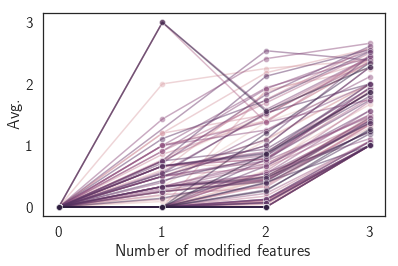

In [19]:
fig, ax = plt.subplots()
sns.lineplot(
    data=trans_data_df.sort_values('perf'),
    x='cost', y='perf', hue='initial',
    ci=None, legend=False, marker='o', markevery=1, alpha=.5,
    ax=ax)

ax.set_xticks([0, 1, 2, 3])
ax.set_xlabel('Number of modified features')
ax.set_ylabel('Avg. ')# + performance_metric_fn.__doc__)

fig.tight_layout()
plt.savefig(os.path.join(IMAGES_DIR, 'evasion_avg_trajectories.pdf'))

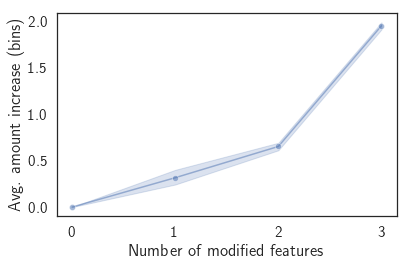

In [20]:
fig, ax = plt.subplots()
sns.lineplot(
    data=trans_data_df.sort_values('perf'),
    x='cost', y='perf', ci=99,
    legend=False, marker='o', markevery=1, alpha=.5,
    ax=ax)

ax.set_xticks([0, 1, 2, 3])
ax.set_xlabel('Number of modified features')
ax.set_ylabel('Avg. ' + performance_metric_fn.__doc__)

plt.plot()

fig.tight_layout()
plt.savefig(os.path.join(IMAGES_DIR, 'evasion_avg_ci.pdf'))

## Plot best-performing adversarial examples

In [21]:
best_transformations = {}
for i in transformations_by_idx.keys():
    ts = transformations_by_idx[i]
    if len(ts) > 0:
        ps = performance_metric_fn(initial_examples_dataset[i], ts)
        best_idx = max(range(len(ts)), key=lambda idx: ps[idx])
        best_transformations[i] = ts[best_idx]

In [22]:
best_trans_df = pd.DataFrame(columns=['initial', 'cost', 'perf'])
for i, t in tqdm_notebook(best_transformations.items()):
    c = cost_fn(initial_examples_dataset[i], [t])[0]
    p = performance_metric_fn(initial_examples_dataset[i], [t])[0]
    #best_trans_df = best_trans_df.append(
    #    {'initial': i, 'cost': 0., 'perf': 0.}, ignore_index=True)
    best_trans_df = best_trans_df.append(
        {'initial': i, 'cost': c, 'perf': p}, ignore_index=True)

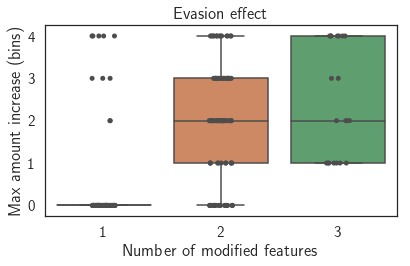

In [23]:
fig, ax = plt.subplots()

sns.boxplot(
    data=best_trans_df.sort_values('perf'),
    x='cost', y='perf', 
    ax=ax, showfliers=False
)
sns.stripplot(
    data=best_trans_df.sort_values('perf'),
    x='cost', y='perf', 
    alpha=1, ax=ax,
    color=".3",
    jitter=True,
)

ax.set_xticklabels([1, 2, 3])
ax.set_xlabel('Number of modified features')
ax.set_ylabel('Max ' + performance_metric_fn.__doc__)
ax.set_title('Evasion effect')

fig.tight_layout()
plt.savefig(os.path.join(IMAGES_DIR, 'evasion_max_strip.pdf'))

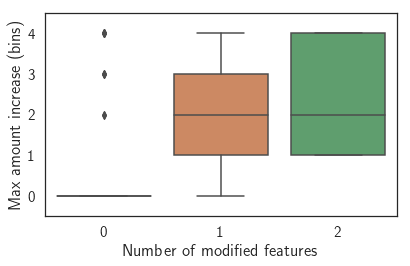

In [24]:
fig, ax = plt.subplots()

sns.boxplot(
    data=best_trans_df.sort_values('perf'),
    x='cost', y='perf'
)

ax.set_xticks([0, 1, 2])
ax.set_xticklabels(['0', '1', '2'])
ax.set_xlabel('Number of modified features')
ax.set_yticks([0, 1, 2, 3, 4])
ax.set_yticklabels(['0', '1', '2', '3', '4'])
ax.set_ylabel('Max ' + performance_metric_fn.__doc__)
ax.set_ylim(-0.5, 4.5)

fig.tight_layout()
plt.savefig(os.path.join(IMAGES_DIR, 'evasion_max_boxes.pdf'))

In [25]:
def diff(x, t):
    diff_idx = np.where(x != t)
    diff_df = pd.DataFrame([x[diff_idx], t[diff_idx]],
                           columns=df.columns[diff_idx])
    return diff_df

In [26]:
from IPython.display import display

for i, t in best_transformations.items():
    orig = X[i]
    display(diff(orig, t))

,"Duration_(24.0, 30.0]","Duration_(30.0, 72.0]"
0,0,1
1,1,0


,"Duration_(12.0, 15.0]","Duration_(30.0, 72.0]"
0,0,1
1,1,0


,"Duration_(12.0, 15.0]","Duration_(15.0, 24.0]"
0,0,1
1,1,0


,"Duration_(15.0, 24.0]","Duration_(24.0, 30.0]"
0,0,1
1,1,0


,"Credit amount_(1262.0, 1906.8]","Credit amount_(4720.0, 18424.0]","Duration_(3.999, 12.0]","Duration_(12.0, 15.0]"
0,1,0,1,0
1,0,1,0,1


,"Credit amount_(2852.4, 4720.0]","Credit amount_(4720.0, 18424.0]","Duration_(12.0, 15.0]","Duration_(30.0, 72.0]",Purpose_business,Purpose_vacation/others
0,1,0,0,1,1,0
1,0,1,1,0,0,1


,"Credit amount_(249.999, 1262.0]","Credit amount_(4720.0, 18424.0]","Duration_(12.0, 15.0]","Duration_(15.0, 24.0]"
0,1,0,0,1
1,0,1,1,0


,"Credit amount_(1262.0, 1906.8]","Credit amount_(4720.0, 18424.0]","Duration_(12.0, 15.0]","Duration_(15.0, 24.0]"
0,1,0,0,1
1,0,1,1,0


,Purpose_car,Purpose_radio/TV
0,1,0
1,0,1


,"Duration_(12.0, 15.0]","Duration_(30.0, 72.0]"
0,0,1
1,1,0


,"Duration_(12.0, 15.0]","Duration_(24.0, 30.0]"
0,0,1
1,1,0


,"Duration_(12.0, 15.0]","Duration_(30.0, 72.0]"
0,0,1
1,1,0


,"Duration_(15.0, 24.0]","Duration_(24.0, 30.0]"
0,0,1
1,1,0


,"Credit amount_(1906.8, 2852.4]","Credit amount_(4720.0, 18424.0]","Duration_(15.0, 24.0]","Duration_(30.0, 72.0]"
0,1,0,0,1
1,0,1,1,0


,"Duration_(12.0, 15.0]","Duration_(30.0, 72.0]"
0,0,1
1,1,0


,"Credit amount_(1906.8, 2852.4]","Credit amount_(4720.0, 18424.0]","Duration_(15.0, 24.0]","Duration_(30.0, 72.0]"
0,1,0,0,1
1,0,1,1,0


,"Duration_(24.0, 30.0]","Duration_(30.0, 72.0]"
0,0,1
1,1,0


,"Credit amount_(1262.0, 1906.8]","Credit amount_(4720.0, 18424.0]","Duration_(24.0, 30.0]","Duration_(30.0, 72.0]"
0,1,0,0,1
1,0,1,1,0


,"Credit amount_(1906.8, 2852.4]","Credit amount_(4720.0, 18424.0]",Purpose_education,Purpose_vacation/others
0,1,0,1,0
1,0,1,0,1


,"Credit amount_(2852.4, 4720.0]","Credit amount_(4720.0, 18424.0]","Duration_(12.0, 15.0]","Duration_(30.0, 72.0]"
0,1,0,0,1
1,0,1,1,0


,"Duration_(15.0, 24.0]","Duration_(30.0, 72.0]"
0,0,1
1,1,0


,"Duration_(24.0, 30.0]","Duration_(30.0, 72.0]",Purpose_business,Purpose_radio/TV
0,0,1,1,0
1,1,0,0,1


,"Credit amount_(1906.8, 2852.4]","Credit amount_(4720.0, 18424.0]","Duration_(15.0, 24.0]","Duration_(30.0, 72.0]"
0,1,0,0,1
1,0,1,1,0


,"Duration_(15.0, 24.0]","Duration_(24.0, 30.0]"
0,1,0
1,0,1


,"Duration_(12.0, 15.0]","Duration_(30.0, 72.0]"
0,0,1
1,1,0


,"Credit amount_(1262.0, 1906.8]","Credit amount_(4720.0, 18424.0]","Duration_(12.0, 15.0]","Duration_(15.0, 24.0]"
0,1,0,0,1
1,0,1,1,0


,"Duration_(24.0, 30.0]","Duration_(30.0, 72.0]"
0,0,1
1,1,0


,"Duration_(24.0, 30.0]","Duration_(30.0, 72.0]",Purpose_education,Purpose_vacation/others
0,0,1,1,0
1,1,0,0,1


,"Duration_(15.0, 24.0]","Duration_(30.0, 72.0]"
0,0,1
1,1,0


,"Credit amount_(1906.8, 2852.4]","Credit amount_(4720.0, 18424.0]","Duration_(12.0, 15.0]","Duration_(15.0, 24.0]"
0,1,0,0,1
1,0,1,1,0


,"Duration_(24.0, 30.0]","Duration_(30.0, 72.0]",Purpose_furniture/equipment,Purpose_vacation/others
0,0,1,1,0
1,1,0,0,1


,"Credit amount_(249.999, 1262.0]","Credit amount_(4720.0, 18424.0]","Duration_(12.0, 15.0]","Duration_(15.0, 24.0]"
0,1,0,0,1
1,0,1,1,0


,"Credit amount_(249.999, 1262.0]","Credit amount_(4720.0, 18424.0]","Duration_(3.999, 12.0]","Duration_(12.0, 15.0]"
0,1,0,0,1
1,0,1,1,0


,"Credit amount_(1906.8, 2852.4]","Credit amount_(4720.0, 18424.0]","Duration_(12.0, 15.0]","Duration_(15.0, 24.0]"
0,1,0,0,1
1,0,1,1,0


,"Credit amount_(2852.4, 4720.0]","Credit amount_(4720.0, 18424.0]","Duration_(12.0, 15.0]","Duration_(15.0, 24.0]",Purpose_education,Purpose_furniture/equipment
0,1,0,0,1,1,0
1,0,1,1,0,0,1


,"Credit amount_(249.999, 1262.0]","Credit amount_(4720.0, 18424.0]","Duration_(12.0, 15.0]","Duration_(15.0, 24.0]"
0,1,0,0,1
1,0,1,1,0


,"Credit amount_(1262.0, 1906.8]","Credit amount_(4720.0, 18424.0]"
0,1,0
1,0,1


,"Duration_(3.999, 12.0]","Duration_(12.0, 15.0]"
0,1,0
1,0,1


,"Credit amount_(2852.4, 4720.0]","Credit amount_(4720.0, 18424.0]","Duration_(15.0, 24.0]","Duration_(30.0, 72.0]"
0,1,0,0,1
1,0,1,1,0


,"Credit amount_(249.999, 1262.0]","Credit amount_(4720.0, 18424.0]",Purpose_furniture/equipment,Purpose_radio/TV
0,1,0,1,0
1,0,1,0,1


,"Credit amount_(249.999, 1262.0]","Credit amount_(4720.0, 18424.0]","Duration_(3.999, 12.0]","Duration_(12.0, 15.0]",Purpose_education,Purpose_furniture/equipment
0,1,0,1,0,1,0
1,0,1,0,1,0,1


,Purpose_car,Purpose_radio/TV
0,1,0
1,0,1


,"Duration_(12.0, 15.0]","Duration_(15.0, 24.0]"
0,0,1
1,1,0


,"Duration_(12.0, 15.0]","Duration_(24.0, 30.0]"
0,0,1
1,1,0


,"Credit amount_(2852.4, 4720.0]","Credit amount_(4720.0, 18424.0]","Duration_(12.0, 15.0]","Duration_(15.0, 24.0]"
0,1,0,0,1
1,0,1,1,0


,"Credit amount_(249.999, 1262.0]","Credit amount_(4720.0, 18424.0]","Duration_(15.0, 24.0]","Duration_(24.0, 30.0]"
0,1,0,1,0
1,0,1,0,1


,"Credit amount_(2852.4, 4720.0]","Credit amount_(4720.0, 18424.0]","Duration_(12.0, 15.0]","Duration_(30.0, 72.0]"
0,1,0,0,1
1,0,1,1,0


,"Credit amount_(1906.8, 2852.4]","Credit amount_(4720.0, 18424.0]",Purpose_car,Purpose_radio/TV
0,1,0,1,0
1,0,1,0,1


,"Duration_(12.0, 15.0]","Duration_(24.0, 30.0]"
0,0,1
1,1,0


,"Duration_(12.0, 15.0]","Duration_(30.0, 72.0]",Purpose_car,Purpose_furniture/equipment
0,0,1,1,0
1,1,0,0,1


,"Duration_(12.0, 15.0]","Duration_(30.0, 72.0]"
0,0,1
1,1,0


,"Credit amount_(249.999, 1262.0]","Credit amount_(4720.0, 18424.0]","Duration_(12.0, 15.0]","Duration_(15.0, 24.0]"
0,1,0,0,1
1,0,1,1,0


,"Duration_(15.0, 24.0]","Duration_(30.0, 72.0]"
0,0,1
1,1,0


,"Duration_(12.0, 15.0]","Duration_(15.0, 24.0]"
0,0,1
1,1,0


,"Duration_(24.0, 30.0]","Duration_(30.0, 72.0]",Purpose_furniture/equipment,Purpose_radio/TV
0,0,1,1,0
1,1,0,0,1


,"Credit amount_(1906.8, 2852.4]","Credit amount_(4720.0, 18424.0]","Duration_(12.0, 15.0]","Duration_(30.0, 72.0]"
0,1,0,0,1
1,0,1,1,0


,"Credit amount_(1906.8, 2852.4]","Credit amount_(4720.0, 18424.0]","Duration_(12.0, 15.0]","Duration_(15.0, 24.0]"
0,1,0,0,1
1,0,1,1,0


,"Duration_(15.0, 24.0]","Duration_(30.0, 72.0]",Purpose_car,Purpose_radio/TV
0,0,1,1,0
1,1,0,0,1


,"Duration_(24.0, 30.0]","Duration_(30.0, 72.0]"
0,0,1
1,1,0


,"Credit amount_(2852.4, 4720.0]","Credit amount_(4720.0, 18424.0]","Duration_(12.0, 15.0]","Duration_(15.0, 24.0]"
0,1,0,0,1
1,0,1,1,0


,"Duration_(12.0, 15.0]","Duration_(15.0, 24.0]"
0,0,1
1,1,0


,"Credit amount_(2852.4, 4720.0]","Credit amount_(4720.0, 18424.0]","Duration_(12.0, 15.0]","Duration_(15.0, 24.0]"
0,1,0,0,1
1,0,1,1,0


,"Duration_(3.999, 12.0]","Duration_(12.0, 15.0]",Purpose_radio/TV,Purpose_vacation/others
0,1,0,1,0
1,0,1,0,1


,"Credit amount_(249.999, 1262.0]","Credit amount_(4720.0, 18424.0]"
0,1,0
1,0,1


,"Credit amount_(1906.8, 2852.4]","Credit amount_(4720.0, 18424.0]","Duration_(12.0, 15.0]","Duration_(24.0, 30.0]",Purpose_furniture/equipment,Purpose_vacation/others
0,1,0,0,1,1,0
1,0,1,1,0,0,1


,"Credit amount_(1906.8, 2852.4]","Credit amount_(4720.0, 18424.0]","Duration_(12.0, 15.0]","Duration_(15.0, 24.0]"
0,1,0,0,1
1,0,1,1,0


,"Credit amount_(2852.4, 4720.0]","Credit amount_(4720.0, 18424.0]","Duration_(12.0, 15.0]","Duration_(15.0, 24.0]",Purpose_furniture/equipment,Purpose_vacation/others
0,1,0,0,1,1,0
1,0,1,1,0,0,1


,"Duration_(15.0, 24.0]","Duration_(30.0, 72.0]"
0,0,1
1,1,0


,"Duration_(12.0, 15.0]","Duration_(30.0, 72.0]",Purpose_business,Purpose_car
0,0,1,1,0
1,1,0,0,1


,"Duration_(15.0, 24.0]","Duration_(30.0, 72.0]"
0,0,1
1,1,0


,Purpose_car,Purpose_radio/TV
0,1,0
1,0,1


,"Duration_(12.0, 15.0]","Duration_(15.0, 24.0]"
0,0,1
1,1,0


,Purpose_education,Purpose_vacation/others
0,1,0
1,0,1


,"Credit amount_(1906.8, 2852.4]","Credit amount_(4720.0, 18424.0]","Duration_(12.0, 15.0]","Duration_(30.0, 72.0]"
0,1,0,0,1
1,0,1,1,0


,"Credit amount_(1262.0, 1906.8]","Credit amount_(4720.0, 18424.0]","Duration_(12.0, 15.0]","Duration_(15.0, 24.0]"
0,1,0,0,1
1,0,1,1,0


,"Duration_(12.0, 15.0]","Duration_(15.0, 24.0]"
0,0,1
1,1,0


,"Credit amount_(249.999, 1262.0]","Credit amount_(4720.0, 18424.0]"
0,1,0
1,0,1


,"Credit amount_(1906.8, 2852.4]","Credit amount_(4720.0, 18424.0]"
0,1,0
1,0,1


,"Credit amount_(249.999, 1262.0]","Credit amount_(4720.0, 18424.0]","Duration_(12.0, 15.0]","Duration_(15.0, 24.0]"
0,1,0,0,1
1,0,1,1,0


,"Duration_(15.0, 24.0]","Duration_(30.0, 72.0]",Purpose_furniture/equipment,Purpose_radio/TV
0,0,1,1,0
1,1,0,0,1


,"Credit amount_(1262.0, 1906.8]","Credit amount_(4720.0, 18424.0]","Duration_(12.0, 15.0]","Duration_(30.0, 72.0]"
0,1,0,0,1
1,0,1,1,0


,"Duration_(12.0, 15.0]","Duration_(15.0, 24.0]"
0,0,1
1,1,0


,"Credit amount_(1262.0, 1906.8]","Credit amount_(4720.0, 18424.0]","Duration_(12.0, 15.0]","Duration_(15.0, 24.0]"
0,1,0,0,1
1,0,1,1,0


,"Credit amount_(249.999, 1262.0]","Credit amount_(4720.0, 18424.0]","Duration_(3.999, 12.0]","Duration_(12.0, 15.0]",Purpose_education,Purpose_furniture/equipment
0,1,0,1,0,1,0
1,0,1,0,1,0,1


,"Credit amount_(2852.4, 4720.0]","Credit amount_(4720.0, 18424.0]","Duration_(12.0, 15.0]","Duration_(15.0, 24.0]",Purpose_furniture/equipment,Purpose_vacation/others
0,1,0,0,1,1,0
1,0,1,1,0,0,1


,"Duration_(15.0, 24.0]","Duration_(24.0, 30.0]",Purpose_business,Purpose_radio/TV
0,0,1,1,0
1,1,0,0,1


,"Duration_(15.0, 24.0]","Duration_(30.0, 72.0]"
0,0,1
1,1,0


,"Duration_(12.0, 15.0]","Duration_(30.0, 72.0]"
0,0,1
1,1,0


,"Credit amount_(249.999, 1262.0]","Credit amount_(4720.0, 18424.0]","Duration_(12.0, 15.0]","Duration_(15.0, 24.0]",Purpose_car,Purpose_vacation/others
0,1,0,0,1,1,0
1,0,1,1,0,0,1


,"Duration_(24.0, 30.0]","Duration_(30.0, 72.0]"
0,0,1
1,1,0


,"Duration_(12.0, 15.0]","Duration_(30.0, 72.0]"
0,0,1
1,1,0


,"Credit amount_(1906.8, 2852.4]","Credit amount_(4720.0, 18424.0]","Duration_(3.999, 12.0]","Duration_(30.0, 72.0]",Purpose_car,Purpose_radio/TV
0,1,0,0,1,0,1
1,0,1,1,0,1,0


,"Credit amount_(1906.8, 2852.4]","Credit amount_(4720.0, 18424.0]"
0,1,0
1,0,1


,"Duration_(24.0, 30.0]","Duration_(30.0, 72.0]",Purpose_car,Purpose_radio/TV
0,0,1,1,0
1,1,0,0,1


,"Credit amount_(1262.0, 1906.8]","Credit amount_(4720.0, 18424.0]","Duration_(12.0, 15.0]","Duration_(15.0, 24.0]"
0,1,0,0,1
1,0,1,1,0


,"Duration_(12.0, 15.0]","Duration_(30.0, 72.0]"
0,0,1
1,1,0


,"Credit amount_(1262.0, 1906.8]","Credit amount_(4720.0, 18424.0]","Duration_(12.0, 15.0]","Duration_(15.0, 24.0]"
0,1,0,0,1
1,0,1,1,0


,"Credit amount_(1262.0, 1906.8]","Credit amount_(4720.0, 18424.0]"
0,1,0
1,0,1


,"Duration_(12.0, 15.0]","Duration_(30.0, 72.0]"
0,0,1
1,1,0


,"Credit amount_(2852.4, 4720.0]","Credit amount_(4720.0, 18424.0]","Duration_(12.0, 15.0]","Duration_(15.0, 24.0]"
0,1,0,0,1
1,0,1,1,0


,"Credit amount_(1906.8, 2852.4]","Credit amount_(4720.0, 18424.0]","Duration_(24.0, 30.0]","Duration_(30.0, 72.0]"
0,1,0,0,1
1,0,1,1,0


,"Credit amount_(1906.8, 2852.4]","Credit amount_(4720.0, 18424.0]","Duration_(12.0, 15.0]","Duration_(15.0, 24.0]",Purpose_furniture/equipment,Purpose_vacation/others
0,1,0,0,1,1,0
1,0,1,1,0,0,1


,"Credit amount_(249.999, 1262.0]","Credit amount_(4720.0, 18424.0]","Duration_(12.0, 15.0]","Duration_(15.0, 24.0]"
0,1,0,0,1
1,0,1,1,0


,"Credit amount_(1906.8, 2852.4]","Credit amount_(4720.0, 18424.0]","Duration_(12.0, 15.0]","Duration_(15.0, 24.0]"
0,1,0,0,1
1,0,1,1,0


,"Credit amount_(249.999, 1262.0]","Credit amount_(4720.0, 18424.0]"
0,1,0
1,0,1


,"Credit amount_(1262.0, 1906.8]","Credit amount_(4720.0, 18424.0]","Duration_(12.0, 15.0]","Duration_(15.0, 24.0]",Purpose_car,Purpose_vacation/others
0,1,0,0,1,1,0
1,0,1,1,0,0,1


,"Credit amount_(1262.0, 1906.8]","Credit amount_(4720.0, 18424.0]","Duration_(12.0, 15.0]","Duration_(15.0, 24.0]"
0,1,0,0,1
1,0,1,1,0


,"Credit amount_(1906.8, 2852.4]","Credit amount_(4720.0, 18424.0]","Duration_(15.0, 24.0]","Duration_(30.0, 72.0]"
0,1,0,0,1
1,0,1,1,0


,"Credit amount_(249.999, 1262.0]","Credit amount_(4720.0, 18424.0]",Purpose_domestic appliances,Purpose_vacation/others
0,1,0,1,0
1,0,1,0,1


,"Credit amount_(249.999, 1262.0]","Credit amount_(4720.0, 18424.0]"
0,1,0
1,0,1


,"Credit amount_(2852.4, 4720.0]","Credit amount_(4720.0, 18424.0]","Duration_(12.0, 15.0]","Duration_(15.0, 24.0]",Purpose_car,Purpose_vacation/others
0,1,0,0,1,1,0
1,0,1,1,0,0,1


,"Credit amount_(2852.4, 4720.0]","Credit amount_(4720.0, 18424.0]","Duration_(15.0, 24.0]","Duration_(24.0, 30.0]",Purpose_furniture/equipment,Purpose_radio/TV
0,1,0,0,1,1,0
1,0,1,1,0,0,1


,"Credit amount_(1906.8, 2852.4]","Credit amount_(4720.0, 18424.0]","Duration_(12.0, 15.0]","Duration_(15.0, 24.0]"
0,1,0,0,1
1,0,1,1,0


,"Credit amount_(1262.0, 1906.8]","Credit amount_(4720.0, 18424.0]","Duration_(15.0, 24.0]","Duration_(24.0, 30.0]"
0,1,0,1,0
1,0,1,0,1


,"Credit amount_(1262.0, 1906.8]","Credit amount_(4720.0, 18424.0]","Duration_(12.0, 15.0]","Duration_(15.0, 24.0]"
0,1,0,0,1
1,0,1,1,0


,"Credit amount_(2852.4, 4720.0]","Credit amount_(4720.0, 18424.0]","Duration_(12.0, 15.0]","Duration_(30.0, 72.0]"
0,1,0,0,1
1,0,1,1,0


,"Credit amount_(249.999, 1262.0]","Credit amount_(4720.0, 18424.0]","Duration_(12.0, 15.0]","Duration_(15.0, 24.0]",Purpose_education,Purpose_furniture/equipment
0,1,0,0,1,1,0
1,0,1,1,0,0,1


,"Credit amount_(1262.0, 1906.8]","Credit amount_(4720.0, 18424.0]","Duration_(12.0, 15.0]","Duration_(15.0, 24.0]"
0,1,0,0,1
1,0,1,1,0


,"Duration_(24.0, 30.0]","Duration_(30.0, 72.0]",Purpose_education,Purpose_vacation/others
0,0,1,1,0
1,1,0,0,1


,"Credit amount_(1906.8, 2852.4]","Credit amount_(4720.0, 18424.0]","Duration_(15.0, 24.0]","Duration_(24.0, 30.0]"
0,1,0,1,0
1,0,1,0,1


,"Duration_(24.0, 30.0]","Duration_(30.0, 72.0]"
0,0,1
1,1,0


,"Credit amount_(1906.8, 2852.4]","Credit amount_(4720.0, 18424.0]","Duration_(12.0, 15.0]","Duration_(15.0, 24.0]"
0,1,0,0,1
1,0,1,1,0


,"Duration_(12.0, 15.0]","Duration_(30.0, 72.0]"
0,0,1
1,1,0


,"Duration_(24.0, 30.0]","Duration_(30.0, 72.0]"
0,0,1
1,1,0


,"Credit amount_(249.999, 1262.0]","Credit amount_(2852.4, 4720.0]","Duration_(3.999, 12.0]","Duration_(12.0, 15.0]"
0,1,0,1,0
1,0,1,0,1


,"Duration_(15.0, 24.0]","Duration_(30.0, 72.0]"
0,0,1
1,1,0


,"Credit amount_(249.999, 1262.0]","Credit amount_(4720.0, 18424.0]",Purpose_car,Purpose_furniture/equipment
0,1,0,1,0
1,0,1,0,1


,"Credit amount_(1262.0, 1906.8]","Credit amount_(4720.0, 18424.0]","Duration_(12.0, 15.0]","Duration_(15.0, 24.0]",Purpose_radio/TV,Purpose_vacation/others
0,1,0,0,1,1,0
1,0,1,1,0,0,1


,"Duration_(24.0, 30.0]","Duration_(30.0, 72.0]",Purpose_business,Purpose_radio/TV
0,0,1,1,0
1,1,0,0,1


,"Credit amount_(1906.8, 2852.4]","Credit amount_(4720.0, 18424.0]","Duration_(12.0, 15.0]","Duration_(15.0, 24.0]"
0,1,0,0,1
1,0,1,1,0


,Purpose_car,Purpose_radio/TV
0,1,0
1,0,1


,"Credit amount_(2852.4, 4720.0]","Credit amount_(4720.0, 18424.0]","Duration_(15.0, 24.0]","Duration_(24.0, 30.0]"
0,1,0,0,1
1,0,1,1,0


,"Duration_(15.0, 24.0]","Duration_(30.0, 72.0]"
0,0,1
1,1,0


,"Credit amount_(249.999, 1262.0]","Credit amount_(4720.0, 18424.0]","Duration_(12.0, 15.0]","Duration_(15.0, 24.0]",Purpose_car,Purpose_domestic appliances
0,1,0,0,1,1,0
1,0,1,1,0,0,1


,"Credit amount_(1262.0, 1906.8]","Credit amount_(4720.0, 18424.0]","Duration_(12.0, 15.0]","Duration_(15.0, 24.0]"
0,1,0,0,1
1,0,1,1,0


,"Credit amount_(1906.8, 2852.4]","Credit amount_(4720.0, 18424.0]","Duration_(12.0, 15.0]","Duration_(15.0, 24.0]",Purpose_furniture/equipment,Purpose_vacation/others
0,1,0,0,1,1,0
1,0,1,1,0,0,1


,"Duration_(12.0, 15.0]","Duration_(30.0, 72.0]",Purpose_education,Purpose_radio/TV
0,0,1,1,0
1,1,0,0,1


,"Credit amount_(1262.0, 1906.8]","Credit amount_(4720.0, 18424.0]","Duration_(12.0, 15.0]","Duration_(15.0, 24.0]"
0,1,0,0,1
1,0,1,1,0


,"Duration_(24.0, 30.0]","Duration_(30.0, 72.0]"
0,0,1
1,1,0


,"Credit amount_(249.999, 1262.0]","Credit amount_(4720.0, 18424.0]",Purpose_car,Purpose_domestic appliances
0,1,0,1,0
1,0,1,0,1


,"Duration_(15.0, 24.0]","Duration_(30.0, 72.0]"
0,0,1
1,1,0


,"Duration_(24.0, 30.0]","Duration_(30.0, 72.0]",Purpose_education,Purpose_vacation/others
0,0,1,1,0
1,1,0,0,1


,"Credit amount_(249.999, 1262.0]","Credit amount_(4720.0, 18424.0]"
0,1,0
1,0,1


,"Duration_(12.0, 15.0]","Duration_(15.0, 24.0]"
0,0,1
1,1,0


,"Duration_(12.0, 15.0]","Duration_(30.0, 72.0]"
0,0,1
1,1,0


,"Duration_(15.0, 24.0]","Duration_(30.0, 72.0]"
0,0,1
1,1,0


,"Credit amount_(1262.0, 1906.8]","Credit amount_(4720.0, 18424.0]"
0,1,0
1,0,1


,"Duration_(12.0, 15.0]","Duration_(30.0, 72.0]"
0,0,1
1,1,0


,"Credit amount_(2852.4, 4720.0]","Credit amount_(4720.0, 18424.0]","Duration_(12.0, 15.0]","Duration_(30.0, 72.0]"
0,1,0,0,1
1,0,1,1,0


,"Credit amount_(2852.4, 4720.0]","Credit amount_(4720.0, 18424.0]","Duration_(12.0, 15.0]","Duration_(30.0, 72.0]"
0,1,0,0,1
1,0,1,1,0


,"Duration_(15.0, 24.0]","Duration_(30.0, 72.0]"
0,0,1
1,1,0


,"Duration_(12.0, 15.0]","Duration_(30.0, 72.0]"
0,0,1
1,1,0


,"Credit amount_(1262.0, 1906.8]","Credit amount_(4720.0, 18424.0]","Duration_(12.0, 15.0]","Duration_(15.0, 24.0]"
0,1,0,0,1
1,0,1,1,0


,"Credit amount_(1906.8, 2852.4]","Credit amount_(4720.0, 18424.0]","Duration_(24.0, 30.0]","Duration_(30.0, 72.0]"
0,1,0,0,1
1,0,1,1,0


,"Credit amount_(1262.0, 1906.8]","Credit amount_(4720.0, 18424.0]","Duration_(12.0, 15.0]","Duration_(15.0, 24.0]"
0,1,0,0,1
1,0,1,1,0


,"Duration_(12.0, 15.0]","Duration_(15.0, 24.0]"
0,0,1
1,1,0


,"Duration_(12.0, 15.0]","Duration_(30.0, 72.0]"
0,0,1
1,1,0


,"Credit amount_(249.999, 1262.0]","Credit amount_(4720.0, 18424.0]","Duration_(12.0, 15.0]","Duration_(15.0, 24.0]",Purpose_car,Purpose_vacation/others
0,1,0,0,1,1,0
1,0,1,1,0,0,1


,"Duration_(12.0, 15.0]","Duration_(30.0, 72.0]",Purpose_business,Purpose_furniture/equipment
0,0,1,1,0
1,1,0,0,1


,"Duration_(24.0, 30.0]","Duration_(30.0, 72.0]",Purpose_furniture/equipment,Purpose_vacation/others
0,0,1,1,0
1,1,0,0,1


,"Credit amount_(1906.8, 2852.4]","Credit amount_(4720.0, 18424.0]","Duration_(3.999, 12.0]","Duration_(15.0, 24.0]"
0,1,0,0,1
1,0,1,1,0


,"Credit amount_(1262.0, 1906.8]","Credit amount_(4720.0, 18424.0]","Duration_(12.0, 15.0]","Duration_(15.0, 24.0]"
0,1,0,0,1
1,0,1,1,0


,"Credit amount_(1906.8, 2852.4]","Credit amount_(4720.0, 18424.0]","Duration_(12.0, 15.0]","Duration_(15.0, 24.0]"
0,1,0,0,1
1,0,1,1,0


,"Duration_(24.0, 30.0]","Duration_(30.0, 72.0]"
0,0,1
1,1,0


,"Credit amount_(1906.8, 2852.4]","Credit amount_(4720.0, 18424.0]","Duration_(12.0, 15.0]","Duration_(24.0, 30.0]"
0,1,0,0,1
1,0,1,1,0


,"Credit amount_(1906.8, 2852.4]","Credit amount_(4720.0, 18424.0]","Duration_(12.0, 15.0]","Duration_(15.0, 24.0]"
0,1,0,0,1
1,0,1,1,0


,"Credit amount_(1906.8, 2852.4]","Credit amount_(4720.0, 18424.0]","Duration_(12.0, 15.0]","Duration_(15.0, 24.0]"
0,1,0,0,1
1,0,1,1,0


,"Duration_(12.0, 15.0]","Duration_(15.0, 24.0]"
0,0,1
1,1,0


,"Credit amount_(2852.4, 4720.0]","Credit amount_(4720.0, 18424.0]","Duration_(3.999, 12.0]","Duration_(15.0, 24.0]",Purpose_business,Purpose_car
0,1,0,0,1,1,0
1,0,1,1,0,0,1


,"Duration_(24.0, 30.0]","Duration_(30.0, 72.0]",Purpose_radio/TV,Purpose_vacation/others
0,0,1,0,1
1,1,0,1,0


,"Duration_(12.0, 15.0]","Duration_(15.0, 24.0]"
0,0,1
1,1,0


,"Credit amount_(249.999, 1262.0]","Credit amount_(4720.0, 18424.0]","Duration_(12.0, 15.0]","Duration_(15.0, 24.0]",Purpose_furniture/equipment,Purpose_vacation/others
0,1,0,0,1,1,0
1,0,1,1,0,0,1


,"Duration_(12.0, 15.0]","Duration_(30.0, 72.0]"
0,0,1
1,1,0


,"Duration_(24.0, 30.0]","Duration_(30.0, 72.0]",Purpose_education,Purpose_radio/TV
0,0,1,1,0
1,1,0,0,1


,"Credit amount_(1906.8, 2852.4]","Credit amount_(4720.0, 18424.0]","Duration_(12.0, 15.0]","Duration_(30.0, 72.0]"
0,1,0,0,1
1,0,1,1,0


,"Duration_(15.0, 24.0]","Duration_(30.0, 72.0]"
0,0,1
1,1,0


,"Credit amount_(249.999, 1262.0]","Credit amount_(4720.0, 18424.0]","Duration_(3.999, 12.0]","Duration_(15.0, 24.0]"
0,1,0,0,1
1,0,1,1,0


,"Duration_(3.999, 12.0]","Duration_(30.0, 72.0]",Purpose_business,Purpose_car
0,0,1,1,0
1,1,0,0,1


,"Duration_(12.0, 15.0]","Duration_(30.0, 72.0]"
0,0,1
1,1,0


,"Credit amount_(1262.0, 1906.8]","Credit amount_(4720.0, 18424.0]","Duration_(12.0, 15.0]","Duration_(30.0, 72.0]"
0,1,0,0,1
1,0,1,1,0
